# Comparative Analysis of Machine Learning Classification Algorithms for Employee Turnover in a Pharmaceutical Company #

In [26]:
library(ggplot2)
library(readxl)
library(tidyverse)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest) 
library(gbm)
library(arsenal)
library(pROC)

In [27]:
data <- read_excel("data.xlsx")

Warning message in read_fun(path = path, sheet_i = sheet, limits = limits, shim = shim, :
"NA inserted for an unsupported date prior to 1900"


## Data Cleaning and Feature Engineering ##

Human Resources Research & Development                  Sales 
                    63                    959                    445

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  18.00   30.00   36.00   36.93   43.00   60.00       3 

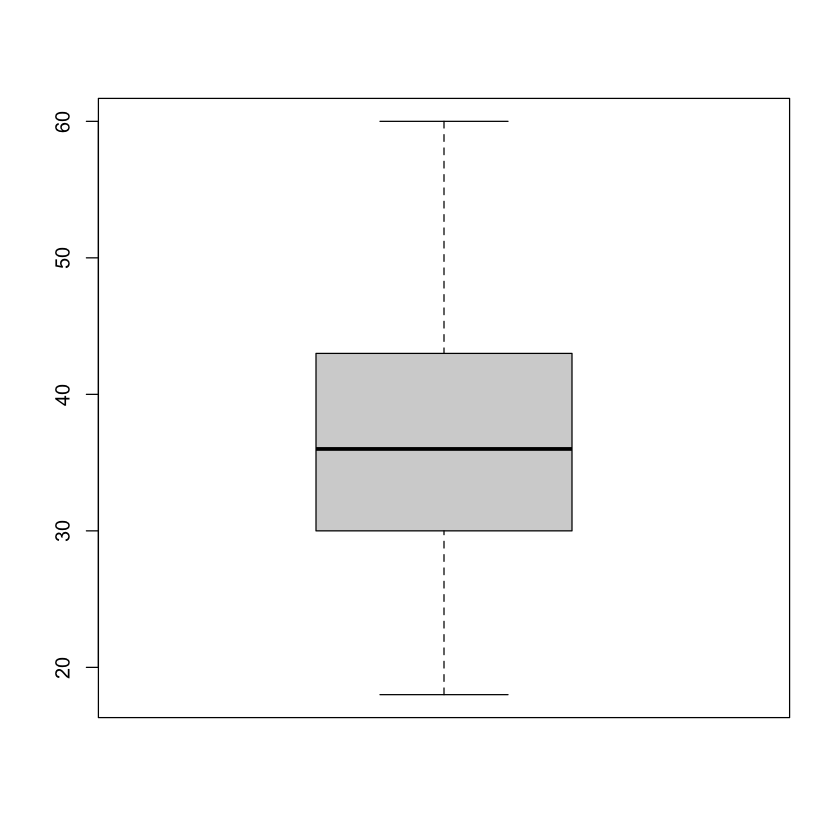

In [30]:
#convert character (text) variables into factors
data <- data %>% mutate_if(is.character,as.factor)

#convert ordinal and categorical variables into factors
colums_factor <- c("Education", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel", "JobSatisfaction", "PerformanceRating", "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance")
data[colums_factor] <- lapply(data[colums_factor], as.factor) 

##incorrect data 
#department  
data <- data %>% 
  mutate(Department = recode(Department, 'HR' = 'Human Resources')) %>%
  mutate(Department = recode(Department, 'R & D' = "Research & Development")) 

summary(data$Department)

##numeric variables (check for outliers)
#Age
boxplot(data$Age) 
summary(data$Age) 
data$Age[data$Age > 70] <- NA 
data$Age[data$Age < 10] <- NA 

#The same process was applied to all numerical variables, yet no outliers were detected among them.




## Statistic Summary and Correlation Analysis ##

Statistic Summary by comparing all variables with the target variable (Attrition). ANOVA Test for numerical variables and Chi Squared Test for categotical variables. Taking \<0.01 as the reference value.

In [31]:
#exclude ID, DOB and Over 18 variables because they are not going to have any implications in the model 
data <- data %>%  select(-ID)
data <- data %>%  select(-DOB)
data <-data %>% select(-Over18)

my_controls <- tableby.control(
  test = T,
  total = FALSE,
  numeric.test = "anova", cat.test = "chisq",
  numeric.stats = c("meansd"),
  cat.stats = c("countpct"),
  )

descriptive_stats <- tableby(Attrition ~ .,
                             data = data,
                             control = my_controls)

summary(descriptive_stats, title = "Descriptive Statistic", text= TRUE)

Warning message in anova.lm(aov.out):
"ANOVA F-tests on an essentially perfect fit are unreliable"




Table: Descriptive Statistic

|                             |     No (N=1186)      |     Yes (N=281)      | p value|
|:----------------------------|:--------------------:|:--------------------:|-------:|
|Age                          |                      |                      | < 0.001|
|-  Mean (SD)                 |    37.615 (8.869)    |    34.018 (9.677)    |        |
|TravelFreq                   |                      |                      | < 0.001|
|-  Frequently                |     201 (16.9%)      |      75 (26.7%)      |        |
|-  None                      |     133 (11.2%)      |      17 (6.0%)       |        |
|-  Rarely                    |     852 (71.8%)      |     189 (67.3%)      |        |
|BillableRate                 |                      |                      |   0.089|
|-  Mean (SD)                 |  811.621 (403.089)   |  766.068 (403.877)   |        |
|Department                   |                      |                      | < 0.001|
|-  Human R

## Models ##

In [32]:
#omit missing values
data <- na.omit(data)

set.seed(0000)

#split the data 
index <- createDataPartition(data$Attrition, p = 0.8, list = FALSE)
train <- data[index,]
test <- data[-index, ]

### Decision Tree ###

In [47]:
tree <- rpart(Attrition~., data = train, method = "class")

In [34]:
#Check accuracy with test data
predictions <- predict(tree, test, type = "class")
postResample(predictions, test$Attrition)

Accuracy     Kappa 
0.8630137 0.5115423

In [35]:
#Confusion matrix
cm_tree <- confusionMatrix(data = predictions, test$Attrition, positive = "Yes")
cm_tree

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  223  27
       Yes  13  29
                                          
               Accuracy : 0.863           
                 95% CI : (0.8182, 0.9003)
    No Information Rate : 0.8082          
    P-Value [Acc > NIR] : 0.008635        
                                          
                  Kappa : 0.5115          
                                          
 Mcnemar's Test P-Value : 0.039833        
                                          
            Sensitivity : 0.51786         
            Specificity : 0.94492         
         Pos Pred Value : 0.69048         
         Neg Pred Value : 0.89200         
             Prevalence : 0.19178         
         Detection Rate : 0.09932         
   Detection Prevalence : 0.14384         
      Balanced Accuracy : 0.73139         
                                          
       'Positive' Class : Yes             
                              

Setting levels: control = No, case = Yes

Setting direction: controls < cases



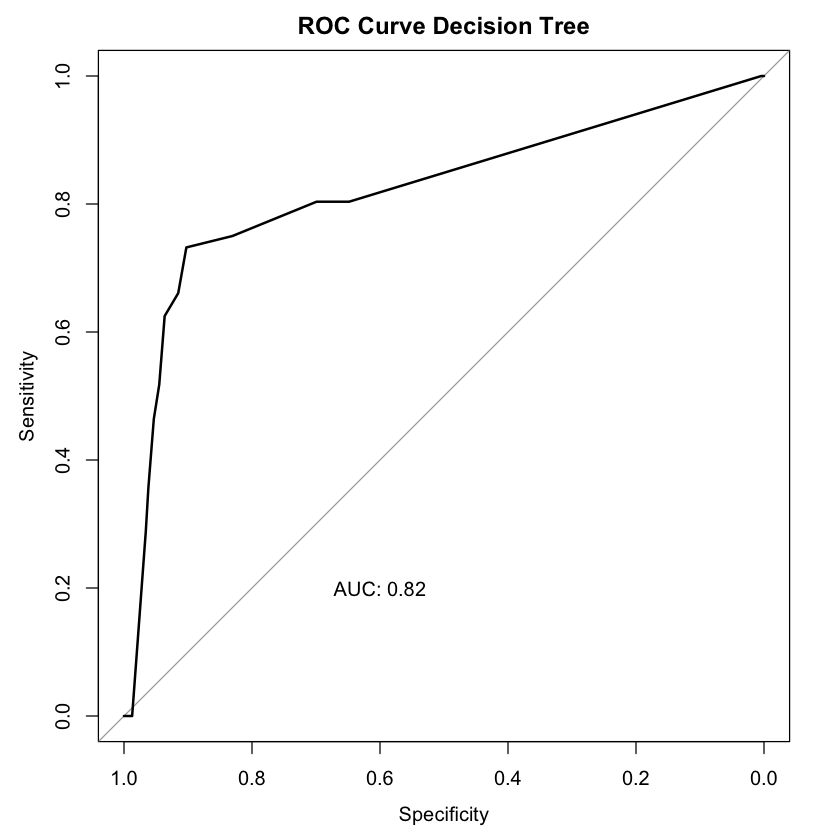

In [36]:
#ROC curve
predictions1 <- predict(tree, test, type = "prob")
probabilities <- predictions1[, "Yes"]
roc_curve <- roc(test$Attrition, probabilities)
area1 <- auc(roc_curve)
plot(roc_curve, main = "ROC Curve Decision Tree")
text(x = 0.6, y = 0.2, labels = paste("AUC:", round(area1, 2)))

### Random Forest ###

In [37]:
rf <- randomForest(Attrition ~ ., data = train)
rf


Call:
 randomForest(formula = Attrition ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 16.21%
Confusion matrix:
     No Yes class.error
No  935  13  0.01371308
Yes 177  47  0.79017857

In [38]:
#check accuracy with the test data
pred_rf <- predict(rf,test)
postResample(pred_rf, test$Attrition)

Accuracy     Kappa 
0.8527397 0.3763163

In [39]:
#Confusion matrix
cm_rf <- confusionMatrix(pred_rf,test$Attrition, positive = "Yes")
cm_rf

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  232  39
       Yes   4  17
                                          
               Accuracy : 0.8527          
                 95% CI : (0.8068, 0.8913)
    No Information Rate : 0.8082          
    P-Value [Acc > NIR] : 0.02867         
                                          
                  Kappa : 0.3763          
                                          
 Mcnemar's Test P-Value : 2.161e-07       
                                          
            Sensitivity : 0.30357         
            Specificity : 0.98305         
         Pos Pred Value : 0.80952         
         Neg Pred Value : 0.85609         
             Prevalence : 0.19178         
         Detection Rate : 0.05822         
   Detection Prevalence : 0.07192         
      Balanced Accuracy : 0.64331         
                                          
       'Positive' Class : Yes             
                              

Setting levels: control = No, case = Yes

Setting direction: controls < cases



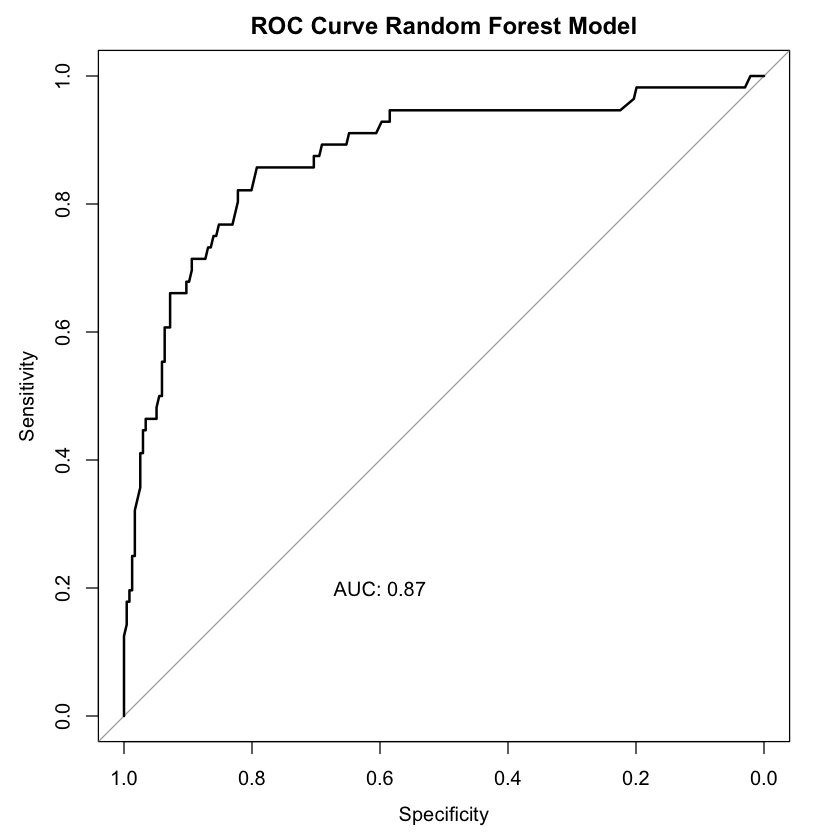

In [40]:
#ROC Curve
pred_rf_prob <- predict(rf, test, type = "prob")
probabilities_rf <- pred_rf_prob[, "Yes"]
roc_curve_rf <- roc(test$Attrition, probabilities_rf)
auc_rf <- auc(roc_curve_rf)
plot(roc_curve_rf, main = "ROC Curve Random Forest Model")
text(x = 0.6, y = 0.2, labels = paste("AUC:", round(auc_rf, 2)))

### Gradient Boosting ### 

In [41]:
# Convert "Yes" to 1 and "No" to 0 in the 'Attrition' variable
train$Attrition <- ifelse(train$Attrition == "Yes", 1, 0)

In [42]:
# Fit the GBM model
gb <- gbm(Attrition ~ .,
                 data = train,
                 distribution = "bernoulli",
                 n.trees = 500,
                 shrinkage = 0.01,
                 interaction.depth = 3,
                 cv.folds = 10,
                 n.minobsinnode = 10)


Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 23: StandardHours has no variation."


In [43]:
#Accuracy with the test data
pred_gb <- predict(gb, test, n.trees = gb$n.trees, type = "response")

In [44]:
#From probabilities to labels 
pred_labels <- ifelse(pred_gb > 0.5, "Yes", "No")

#Confusion Matrix
cm_gb <- confusionMatrix(as.factor(pred_labels), test$Attrition, positive = "Yes")
print(cm_gb)


Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  232  38
       Yes   4  18
                                          
               Accuracy : 0.8562          
                 95% CI : (0.8106, 0.8943)
    No Information Rate : 0.8082          
    P-Value [Acc > NIR] : 0.01971         
                                          
                  Kappa : 0.3962          
                                          
 Mcnemar's Test P-Value : 3.543e-07       
                                          
            Sensitivity : 0.32143         
            Specificity : 0.98305         
         Pos Pred Value : 0.81818         
         Neg Pred Value : 0.85926         
             Prevalence : 0.19178         
         Detection Rate : 0.06164         
   Detection Prevalence : 0.07534         
      Balanced Accuracy : 0.65224         
                                          
       'Positive' Class : Yes             
                              

Setting levels: control = No, case = Yes

Setting direction: controls < cases



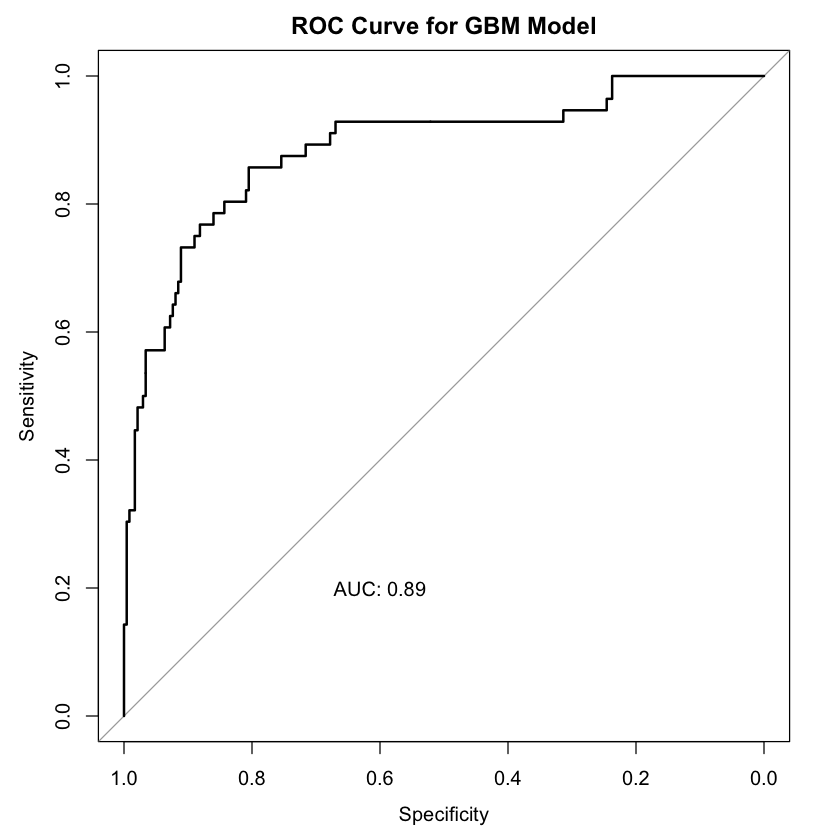

In [45]:
#ROC Curve
roc_curve_gb <- roc(test$Attrition, pred_gb)
auc_gb <- auc(roc_curve_gb)
plot(roc_curve_gb, main = "ROC Curve for GBM Model")
text(x = 0.6, y = 0.2, labels = paste("AUC:", round(auc_gb, 2)))

## Comparision of Models Accuracy ##

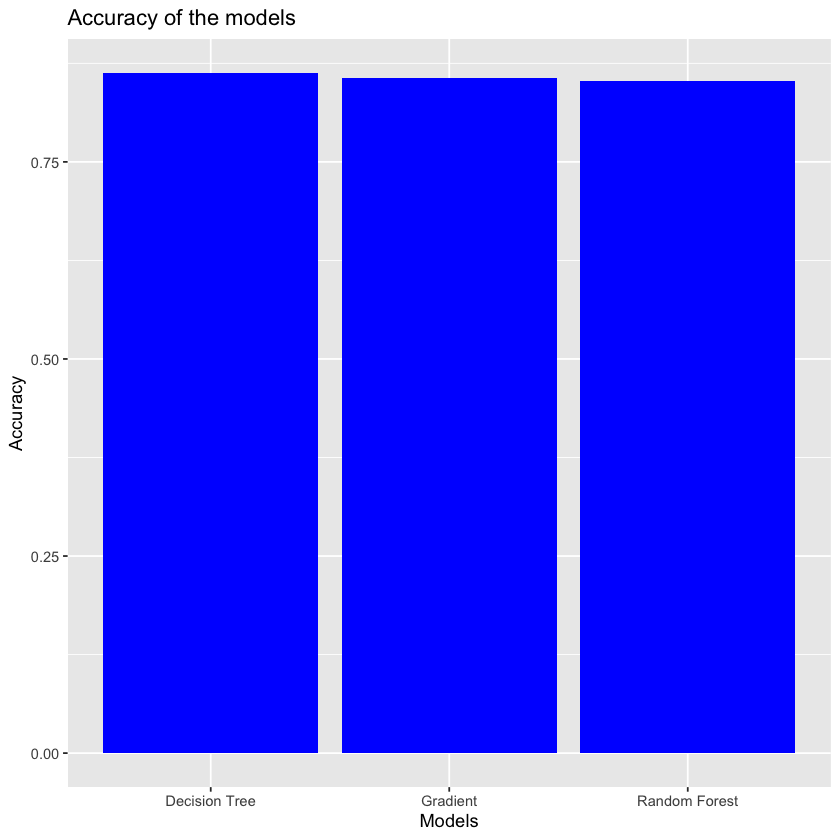

In [46]:
##Comparative of models accuracy
models <- data.frame(Model = c('Random Forest',
                                      'Decision Tree',
                                      'Gradient'),
                            Accuracy = c(cm_rf$overall[1],
                                         cm_tree$overall[1],
                                         cm_gb$overall[1]))

#Plot comparing accuracy 
ggplot(aes(x=Model, y=Accuracy), data=models) +
  geom_bar(stat='identity', fill = 'blue') +
  ggtitle('Accuracy of the models') +
  xlab('Models') +
  ylab('Accuracy')

## Reflective Commentary ##